PROEYCTO FINAL RECONOCIMIENTO DE MOVIMIENTO : TRADUCCION DE LENGUAJE DE SENAS A TEXTO.

INTEGRANTES DEL GRUPO:

1. IMPORTAR LIBRERIAS , VERIFICACION DE VERSIONES ESENCIALES Y RECURSOS DE HARDWARE GPU T4

In [1]:
# Instalar libreria para poder visualizar en forma grafica la arquitenctura de la red neuronal
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 15.1 MB/s eta 0:00:00


In [2]:
# 1.1 Librerías esenciales
from tensorflow.keras.models import Sequential, save_model , load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf  # <-- importar tensorflow
import os
import numpy as np # linear algebra
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, regularizers
import random
import cv2
from glob import glob
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
import visualkeras
import shutil
import pandas as pd
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing import image



In [3]:
# 1.2 Verificamos si la version de Tensorflow es la que se necesita
print("TF Version:", tf.__version__) # debe ser 2.18.0

TF Version: 2.18.0


In [4]:
# 1.3 Verificar existe disponibilidad de GPU en Google Drive
import tensorflow as tf
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# 1.4 Visualizacion de GPU T4
!nvidia-smi

Tue May 13 16:31:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

2. DEFINIR RUTAS DE ACCESO DE GOOGLE COLAB A GOOGLE DRIVE Y CARGAR DATASETS KAGGLE

In [6]:
# 2.1) Se define la ruta para leer los archivos a usar desde la nube Google Colaboratory
     # a Google Drive
BASE_FOLDER = '/content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA/'

# Instruccion que permite importar y montar una unidad de Drive de Google drive en Google colaboratory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# 2.2 ) Se ubica el archivo token generado por la cuenta Kaggle en Google drive
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Descargar dataset
!kaggle datasets download -d grassknoted/asl-alphabet
# Se visualizan los datos
!unzip asl-alphabet.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: /content/data/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: /content/data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: /content/data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: /content/data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: /content/data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: /content/data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: /content/data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: /content/data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: /content/data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: /content/data/asl_alphabet_tr

3. LIMPIEZA DE DATOS

In [11]:
 # 3.1 Definir las clases válidas (A-Z...)

valid_classes = [chr(i) for i in range(65, 91)] + ['del', 'nothing', 'space']

# 3.1.1 Obtener las subcarpetas válidas en el directorio

data_dir = '/content/data/asl_alphabet_train/asl_alphabet_train'
all_subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
filtered_subdirs = sorted([d for d in all_subdirs if d in valid_classes])  # Orden alfabético


In [12]:
# 3.1.2 Visualizar el dataset de entrenamiento
!ls '/content/data/asl_alphabet_train/asl_alphabet_train'

A  C  del  F  H  J  L  N	O  Q  S      T	V  X  Z
B  D  E    G  I  K  M  nothing	P  R  space  U	W  Y


In [13]:
# 3.1.3 Verificamos si el dataset esta balanceado es decir si todas las clases tiene el mismo numero de imagenes
data_dir = '/content/data/asl_alphabet_train/asl_alphabet_train'
for cls in valid_classes:  # ['A', 'B', ..., 'Z']
    cls_dir = os.path.join(data_dir, cls)
    num_images = len(os.listdir(cls_dir))
    print(f"Clase {cls}: {num_images} imágenes")

Clase A: 3000 imágenes
Clase B: 3000 imágenes
Clase C: 3000 imágenes
Clase D: 3000 imágenes
Clase E: 3000 imágenes
Clase F: 3000 imágenes
Clase G: 3000 imágenes
Clase H: 3000 imágenes
Clase I: 3000 imágenes
Clase J: 3000 imágenes
Clase K: 3000 imágenes
Clase L: 3000 imágenes
Clase M: 3000 imágenes
Clase N: 3000 imágenes
Clase O: 3000 imágenes
Clase P: 3000 imágenes
Clase Q: 3000 imágenes
Clase R: 3000 imágenes
Clase S: 3000 imágenes
Clase T: 3000 imágenes
Clase U: 3000 imágenes
Clase V: 3000 imágenes
Clase W: 3000 imágenes
Clase X: 3000 imágenes
Clase Y: 3000 imágenes
Clase Z: 3000 imágenes
Clase del: 3000 imágenes
Clase nothing: 3000 imágenes
Clase space: 3000 imágenes


In [14]:
# 3.2 Visualizacion de las imagenes cargadas

def plot_three_samples(letter):
    # Construir ruta usando os.path para mejor compatibilidad entre sistemas
    data_dir = '/content/data/asl_alphabet_train/asl_alphabet_train'
    class_dir = os.path.join(data_dir, letter)

    # Obtener lista de imágenes con formato correcto
    img_paths = glob(os.path.join(class_dir, '*.jpg'))

    if not img_paths:
        print(f"No se encontraron imágenes para la letra {letter} en: {class_dir}")
        return

    # Seleccionar máximo 3 imágenes
    sample_paths = random.sample(img_paths, min(3, len(img_paths)))

    # Configurar plot
    plt.figure(figsize=(16, 16))
    plt.suptitle(f'Muestras para la letra "{letter}"', fontsize=20, y=0.9)

    # Mostrar imágenes con conversión de color BGR a RGB
    for i, img_path in enumerate(sample_paths, 1):
        plt.subplot(1, 3, i)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)  # Conversión crítica
        plt.imshow(img)
        plt.title(f'Imagen {i}')
        plt.axis('off')

    # Asegurar que se muestre el plot
    plt.tight_layout()
    plt.show()

# Probar con diferentes letras
plot_three_samples('A')
plot_three_samples('B')
plot_three_samples('C')

Output hidden; open in https://colab.research.google.com to view.

In [15]:
# 3.2.1 Verficamos el dataset test como esta su contenido
!ls '/content/data/asl_alphabet_test/asl_alphabet_test'

A_test.jpg  G_test.jpg	M_test.jpg	  R_test.jpg	  W_test.jpg
B_test.jpg  H_test.jpg	nothing_test.jpg  space_test.jpg  X_test.jpg
C_test.jpg  I_test.jpg	N_test.jpg	  S_test.jpg	  Y_test.jpg
D_test.jpg  J_test.jpg	O_test.jpg	  T_test.jpg	  Z_test.jpg
E_test.jpg  K_test.jpg	P_test.jpg	  U_test.jpg
F_test.jpg  L_test.jpg	Q_test.jpg	  V_test.jpg


In [16]:
# 3.2.2 Se ordena y se agrega clase faltante del_test.jpg
# El dataset asl_alphabet_test no viene organizado en sub carpetas por clase y ademas
# no incluye la imagen del_test.jpg solo hay 28 imagenes, por lo que vamos a tomar una imagen asl_alphabet_train
# y traladarla a asl_alphabet_test para luego darle el formato de sub carpetas y tener 29 clases
# para evitar problemas de incosistencia en las clases,

# =============================================
# 1. Definir rutas
# =============================================
# Ruta de la carpeta "del" en entrenamiento
train_del_dir = '/content/data/asl_alphabet_train/asl_alphabet_train/del'

# Ruta del directorio de test (actual)
test_dir = '/content/data/asl_alphabet_test/asl_alphabet_test'

# Nombre del archivo faltante en test
nombre_test_faltante = 'del_test.jpg'

# =============================================
# 2. Copiar la imagen (usaremos la primera imagen de "del" en entrenamiento)
# =============================================
# Verificar que existe al menos una imagen en la carpeta "del"
if os.path.exists(train_del_dir) and len(os.listdir(train_del_dir)) > 0:
    # Tomar la primera imagen (ej: del1.jpg)
    imagen_origen = os.path.join(train_del_dir, os.listdir(train_del_dir)[0])

    # Ruta destino en test (¡con el nombre correcto!)
    imagen_destino = os.path.join(test_dir, nombre_test_faltante)

    # Copiar (no mover para no dañar datos de entrenamiento)
    shutil.copy(imagen_origen, imagen_destino)
    print(f"¡Imagen copiada a: {imagen_destino}!")
else:
    print("Error: No hay imágenes en la carpeta 'del' de entrenamiento")

# =============================================
# 3. Reorganizar el directorio de test (como en la solución anterior)
# =============================================
new_test_dir = '/content/data/asl_alphabet_test_reorganized'  # Nueva carpeta organizada

# Crear subcarpetas para cada clase
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
           'del', 'nothing', 'space']

os.makedirs(new_test_dir, exist_ok=True)

# Mover cada imagen a su subcarpeta correspondiente
for filename in os.listdir(test_dir):
    if filename.endswith(".jpg"):
        # Extraer nombre de clase (ej: "del_test.jpg" -> "del")
        class_name = filename.split("_")[0].lower()

        # Caso especial para "del"
        if filename.startswith("del"):
            class_name = "del"

        # Crear subcarpeta si no existe
        class_dir = os.path.join(new_test_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Mover el archivo
        src = os.path.join(test_dir, filename)
        dst = os.path.join(class_dir, filename)
        shutil.move(src, dst)  # Ahora sí movemos

print("¡Reorganización completada!")

# =============================================
# 4. Verificar resultado
# =============================================
print("\nContenido de la nueva carpeta de test:")
!ls {new_test_dir}

print("\nContenido de la subcarpeta 'del':")
!ls {os.path.join(new_test_dir, 'del')}

¡Imagen copiada a: /content/data/asl_alphabet_test/asl_alphabet_test/del_test.jpg!
¡Reorganización completada!

Contenido de la nueva carpeta de test:
a  c  del  f  h  j  l  n	o  q  s      t	v  x  z
b  d  e    g  i  k  m  nothing	p  r  space  u	w  y

Contenido de la subcarpeta 'del':
del_test.jpg


In [17]:
# 3.2.3 Se ordena y renombran las clases en mayusculas
# el contenido de la carpeta esta en minusculas se convertira en letras mayusculas
test_dir = '/content/data/asl_alphabet_test_reorganized'

# Lista de clases esperadas (29 en total)
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
           'del', 'nothing', 'space']

# Renombrar carpetas de minúsculas a mayúsculas
for class_name in classes:
    lowercase_path = os.path.join(test_dir, class_name.lower())
    correct_path = os.path.join(test_dir, class_name)

    if os.path.exists(lowercase_path):
        os.rename(lowercase_path, correct_path)
        print(f"Renombrado: {class_name.lower()} -> {class_name}")

print("¡Estructura corregida!")

Renombrado: a -> A
Renombrado: b -> B
Renombrado: c -> C
Renombrado: d -> D
Renombrado: e -> E
Renombrado: f -> F
Renombrado: g -> G
Renombrado: h -> H
Renombrado: i -> I
Renombrado: j -> J
Renombrado: k -> K
Renombrado: l -> L
Renombrado: m -> M
Renombrado: n -> N
Renombrado: o -> O
Renombrado: p -> P
Renombrado: q -> Q
Renombrado: r -> R
Renombrado: s -> S
Renombrado: t -> T
Renombrado: u -> U
Renombrado: v -> V
Renombrado: w -> W
Renombrado: x -> X
Renombrado: y -> Y
Renombrado: z -> Z
Renombrado: del -> del
Renombrado: nothing -> nothing
Renombrado: space -> space
¡Estructura corregida!


In [18]:
# 3.2.4 Verificamos si el dataset esta balanceado es decir si todas las clases tiene el mismo numero de imagenes
test_dir = '/content/data/asl_alphabet_test_reorganized'

for cls in valid_classes:  # ['A', 'B', ..., 'Z']
    cls_dir = os.path.join(test_dir, cls)
    num_images = len(os.listdir(cls_dir))
    print(f"Clase {cls}: {num_images} imágenes")

Clase A: 1 imágenes
Clase B: 1 imágenes
Clase C: 1 imágenes
Clase D: 1 imágenes
Clase E: 1 imágenes
Clase F: 1 imágenes
Clase G: 1 imágenes
Clase H: 1 imágenes
Clase I: 1 imágenes
Clase J: 1 imágenes
Clase K: 1 imágenes
Clase L: 1 imágenes
Clase M: 1 imágenes
Clase N: 1 imágenes
Clase O: 1 imágenes
Clase P: 1 imágenes
Clase Q: 1 imágenes
Clase R: 1 imágenes
Clase S: 1 imágenes
Clase T: 1 imágenes
Clase U: 1 imágenes
Clase V: 1 imágenes
Clase W: 1 imágenes
Clase X: 1 imágenes
Clase Y: 1 imágenes
Clase Z: 1 imágenes
Clase del: 1 imágenes
Clase nothing: 1 imágenes
Clase space: 1 imágenes


In [19]:
# 3.2.5 Visualizacion de la distribucion de imagenes en los datasets
clases = sorted(os.listdir(data_dir))
data = []

for clase in clases:
    train_count = len(os.listdir(os.path.join(data_dir, clase)))
    test_count = len(os.listdir(os.path.join(test_dir, clase)))
    data.append([clase, train_count, test_count, train_count + test_count ])

df = pd.DataFrame(data, columns=["Clase", "Train", "Test", "Total"])
print(df.to_string(index=False))

  Clase  Train  Test  Total
      A   3000     1   3001
      B   3000     1   3001
      C   3000     1   3001
      D   3000     1   3001
      E   3000     1   3001
      F   3000     1   3001
      G   3000     1   3001
      H   3000     1   3001
      I   3000     1   3001
      J   3000     1   3001
      K   3000     1   3001
      L   3000     1   3001
      M   3000     1   3001
      N   3000     1   3001
      O   3000     1   3001
      P   3000     1   3001
      Q   3000     1   3001
      R   3000     1   3001
      S   3000     1   3001
      T   3000     1   3001
      U   3000     1   3001
      V   3000     1   3001
      W   3000     1   3001
      X   3000     1   3001
      Y   3000     1   3001
      Z   3000     1   3001
    del   3000     1   3001
nothing   3000     1   3001
  space   3000     1   3001


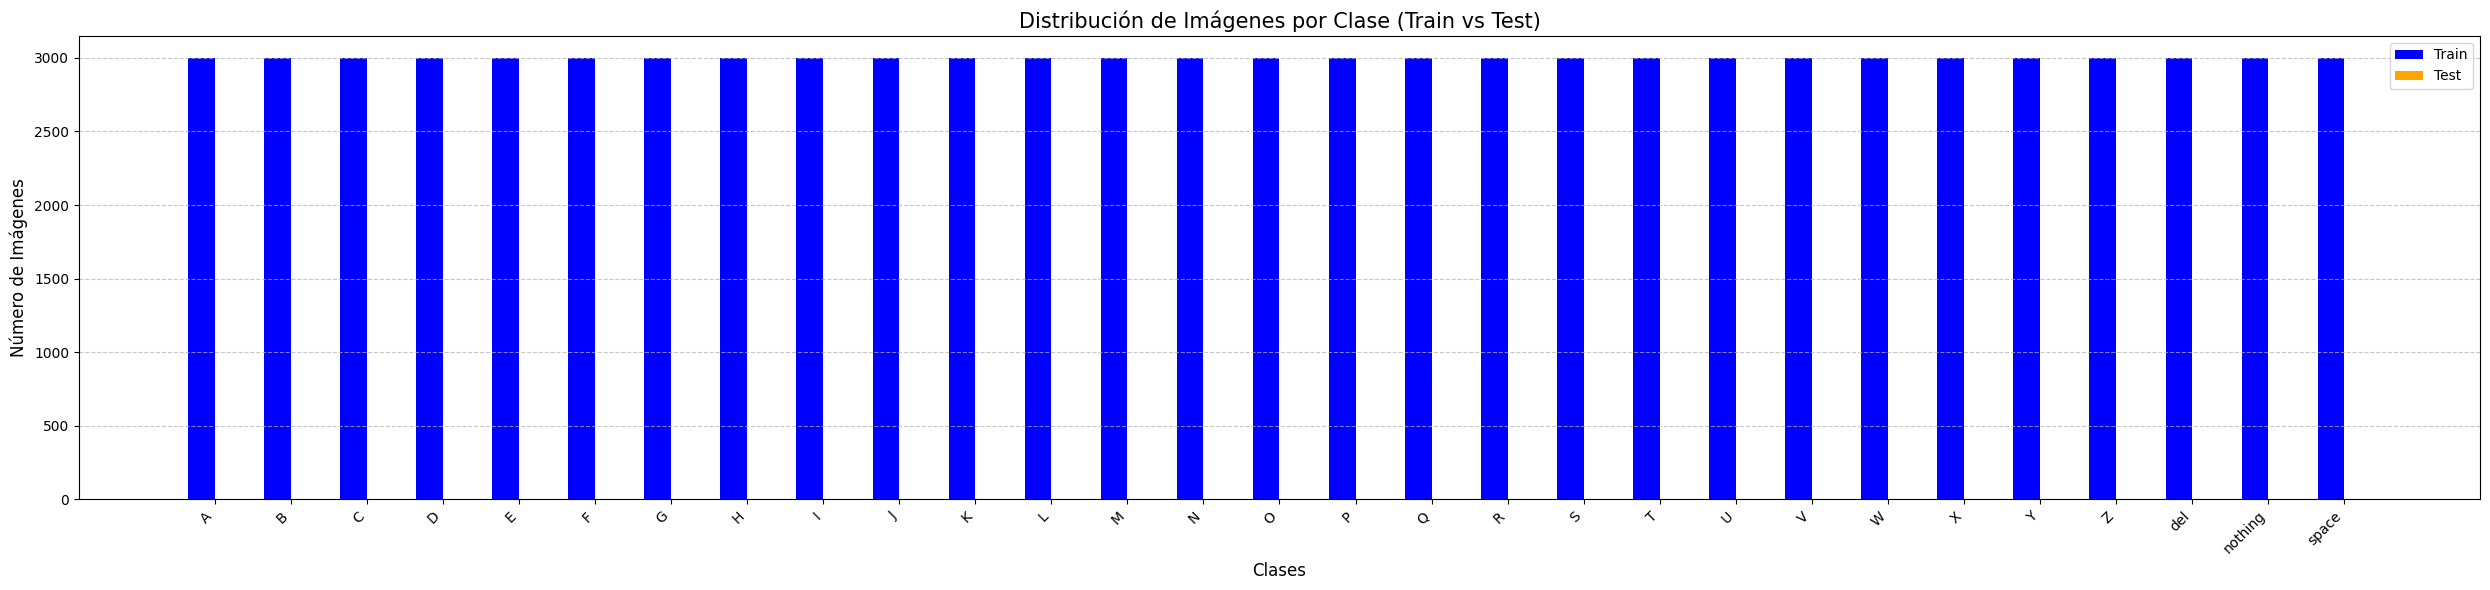

In [22]:
# 3.3 Visualizacion de distribucion de imagenes por clase Entrenamiento y Prueba
# Directorios
train_dir = '/content/data/asl_alphabet_train/asl_alphabet_train'

test_dir = '/content/data/asl_alphabet_test_reorganized'



# Clases ordenadas (A-Z)
clases = sorted(os.listdir(train_dir))  # Asumiendo que todas las clases están presentes en train

# Contar imágenes en train y test
train_counts = []
test_counts = []

for clase in clases:
    train_clase_path = os.path.join(train_dir, clase)
    test_clase_path = os.path.join(test_dir, clase)

    train_counts.append(len(os.listdir(train_clase_path)))
    test_counts.append(len(os.listdir(test_clase_path)))

# Crear gráfico
plt.figure(figsize=(25, 6))
x = np.arange(len(clases))  # Posiciones de las etiquetas
width = 0.35  # Ancho de las barras

plt.bar(x - width/2, train_counts, width, label='Train', color='blue')
plt.bar(x + width/2, test_counts, width, label='Test', color='orange')

plt.xlabel('Clases', fontsize=12)
plt.ylabel('Número de Imágenes', fontsize=12)
plt.title('Distribución de Imágenes por Clase (Train vs Test)', fontsize=15)
plt.xticks(x, clases, rotation=45, ha='right')  # Clases en el eje X
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

4. VALIDACION DE LA RED NEURONAL ARTIFICIAL SECUENCIAL DE CLASIFICACION

In [23]:
# 4.1 Se verifican las dimensiones de las imagenes en formato JPEG

train_dir = '/content/data/asl_alphabet_train/asl_alphabet_train'
clase_ejemplo = 'A'  # Reemplaza con una clase existente
imagen_ejemplo = os.listdir(os.path.join(train_dir, clase_ejemplo))[0]
imagen_path = os.path.join(train_dir, clase_ejemplo, imagen_ejemplo)

# Obtener dimensiones
with Image.open(imagen_path) as img:
    width, height = img.size

print(f"Dimensiones originales: {width}x{height}")

Dimensiones originales: 200x200


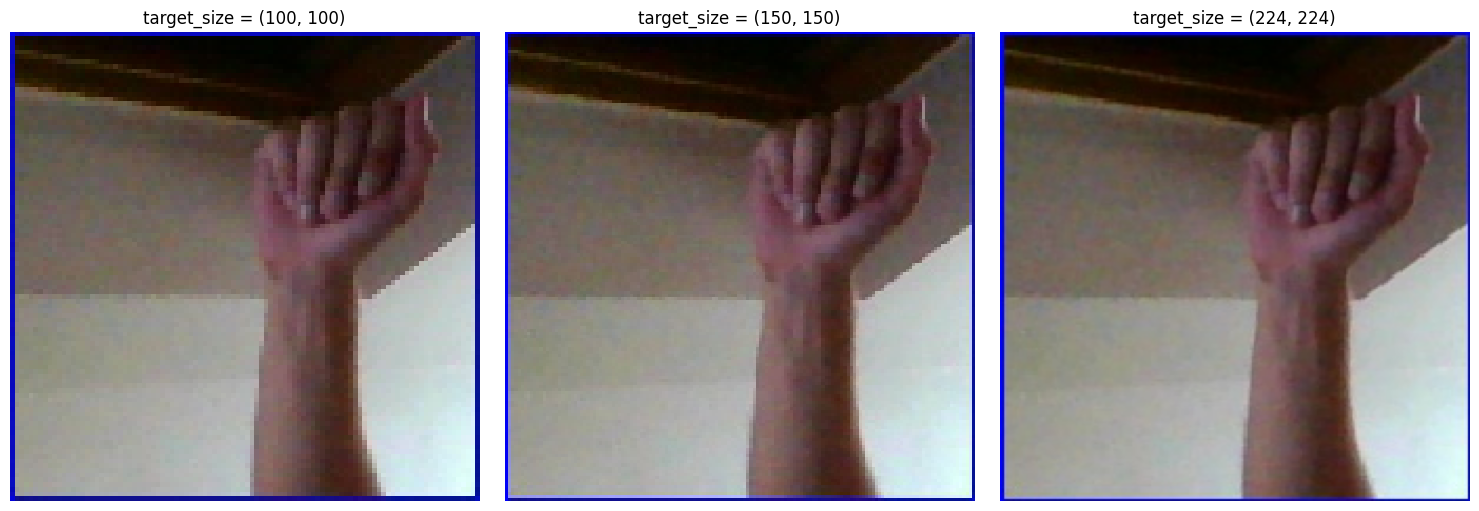

In [24]:
# 4.2 Tamaños a probar de target_size antes de configurar ImageDataGenerator

tamanos = [(100, 100), (150, 150), (224, 224)]

plt.figure(figsize=(15, 5))

for i, size in enumerate(tamanos):
    # Cargar y redimensionar imagen
    img = load_img(imagen_path, target_size=size)

    plt.subplot(1, len(tamanos), i + 1)
    plt.imshow(img)
    plt.title(f'target_size = {size}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [25]:
# 4.3 Parámetrizacion
target_size = (150, 150)  # Aumentar resolución para mejor precisión (si hardware lo permite)
batch_size = 128          # Ajustar según RAM/GPU
val_frac = 0.2

seed = 42  # Semilla fija para reproducibilidad
data_dir = '/content/data/asl_alphabet_train/asl_alphabet_train'

# 4.2 Generador de ENTRENAMIENTO se parametriza para ampliar las imagenes existentes con aumentos de transformaciones
# y prevenir el overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Escaldo de la imagen
    rotation_range=50,              # Rotar imágenes aleatoriamente en el rango (grados, 0 a 180)
    zoom_range=0.4,                 # Ampliar imagen aleatoriamente
    width_shift_range=0.3,          # Desplaza imágenes aleatoriamente de forma horizontal (fracción del ancho total)
    height_shift_range=0.3,         # Desplaza aleatoriamente las imágenes verticalmente (fracción de la altura total)
    shear_range=0.4,               # El rango de corte desplaza la imagen en sentido antihorario en un rango de grados igual al valor flotante elegido
    brightness_range=[0.5, 1.5],    # Esto iluminará u oscurecerá aleatoriamente una imagen dentro de un rango.
    fill_mode='constant',           # Valor negro constante
    validation_split=val_frac,      # Divide los datos de Train y validation (80%,20%)

)

# 4.2.1 Generador de VALIDACIÓN (sin aumentos)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=val_frac,

)

# Flujos de datos con misma semilla para que la división entrenamiento/validación sea reproducible
# 4.2.2 Entrenamiento
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    subset='training',
    shuffle=True,
    seed=seed  # Asegura misma división
)

# 4.2.3 Validacion
val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    subset='validation',
    shuffle=False,
    seed=seed  # Asegura misma división
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


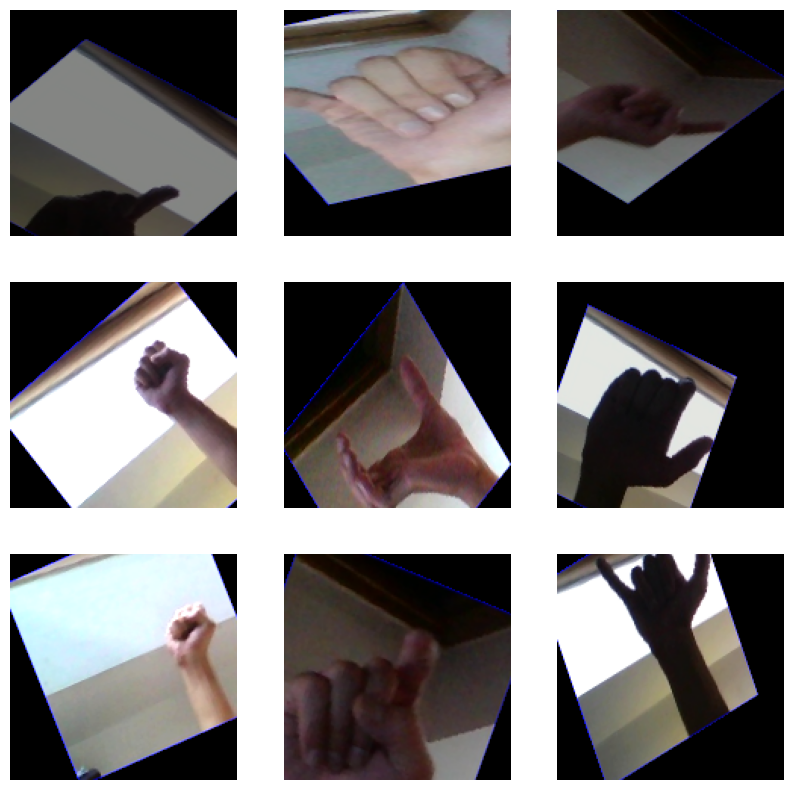

In [27]:
# 4.4 Generar un batch de imágenes aumentadas
augmented_images, labels = next(train_generator)

# Mostrar imágenes
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

In [28]:
# 4.3 Contruccion del modelo de CNN

# =============================================
# 4.3.1 Arquitectura Optimizada para CPU
# =============================================

# Regularización ajustada
conv_reg = regularizers.l2(1e-4)  # Reducido desde 2e-4
dense_reg = regularizers.l2(3e-4)  # L2 puro para capas densas

inputShape = (150, 150, 3)
classes = 29  # Asumiendo 29 clases de ASL

epochs = 50

# =============================================
# 4.3.2 Arquitectura CNN Mejorada (Desde Cero)
# =============================================
model = Sequential(name="ASL_Custom_Pro")


# Bloque 1
model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same',
                       kernel_initializer='he_normal', kernel_regularizer=conv_reg,
                       input_shape=inputShape))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Bloque 2
model.add(layers.Conv2D(128, (3,3), padding='same',kernel_initializer='he_normal', kernel_regularizer=conv_reg))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same',kernel_initializer='he_normal', kernel_regularizer=conv_reg))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.3))  # Reducido desde 0.4

# Bloque 3
model.add(layers.Conv2D(256, (3,3), padding='same',kernel_initializer='he_normal', kernel_regularizer=conv_reg))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same',kernel_initializer='he_normal', kernel_regularizer=conv_reg))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.4))  # Reducido desde 0.5

# Bloque 4
model.add(layers.Conv2D(512, (3,3), padding='same',kernel_initializer='he_normal', kernel_regularizer=conv_reg))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(512, (3,3), strides=(2,2), padding='same',kernel_initializer='he_normal', kernel_regularizer=conv_reg))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))  # Reducido desde 0.6

# Capas Densas
model.add(layers.Flatten())
model.add(layers.Dense(1024, kernel_regularizer=dense_reg))  # Nueva capa intermedia
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))  # Reducido desde 0.7

model.add(layers.Dense(512, kernel_regularizer=dense_reg))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(classes, activation='softmax'))

# =============================================
# 4.3.3 Compilación y Callbacks
# =============================================

# La optimización de Adam es un método de descenso de gradiente estocástico
# que se basa en la estimación adaptativa de momentos de primer y segundo orden.

optimizer = Adam(learning_rate=0.001)  # LR más bajo para estabilidad
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy', # Se utiliza como función de pérdida para el modelo de clasificación de múltiples clases
    metrics=['accuracy']
)

# Detener el entrenamiento cuando la métrica monitoreada haya dejado de mejorar
early_stop = EarlyStopping(
    monitor= "val_accuracy",    # Cantidad a monitorear objetivo de un entrenamiento es minimizar la pérdida
    patience=8,                # Mayor paciencia para convergencia
    restore_best_weights=True, # se deben restaurar los pesos del modelo de la época con el mejor valor de la cantidad monitoreada
    mode="max"

)# ¡Importante! Indica que se busca maximizar la métrica

# Reducir la tasa de aprendizaje cuando la métrica ha dejado de mejorar.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       # Cantidad a monitorear objetivo de un entrenamiento es minimizar la pérdida
    factor=0.5,               # Reduce LR en 80% cuando se estanca
    patience=3,               # Número de épocas sin mejoras después de las cuales se reducirá la tasa de aprendizaje.
    verbose=1,
    mode="min"
) # Límite inferior de la tasa de aprendizaje

# =============================================
# 4.3.4 Visualizar el modelo CNN
# =============================================

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "ASL_Custom_Pro"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 75, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 38, 38, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 38, 38, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 38, 38, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 19, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 19, 19, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 19, 19, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 19, 19, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 19, 19, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 19, 19, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10, 10, 512)    │         2,04

 Total params: 57,634,589 (219.86 MB)

 Trainable params: 57,627,805 (219.83 MB)

 Non-trainable params: 6,784 (26.50 KB)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


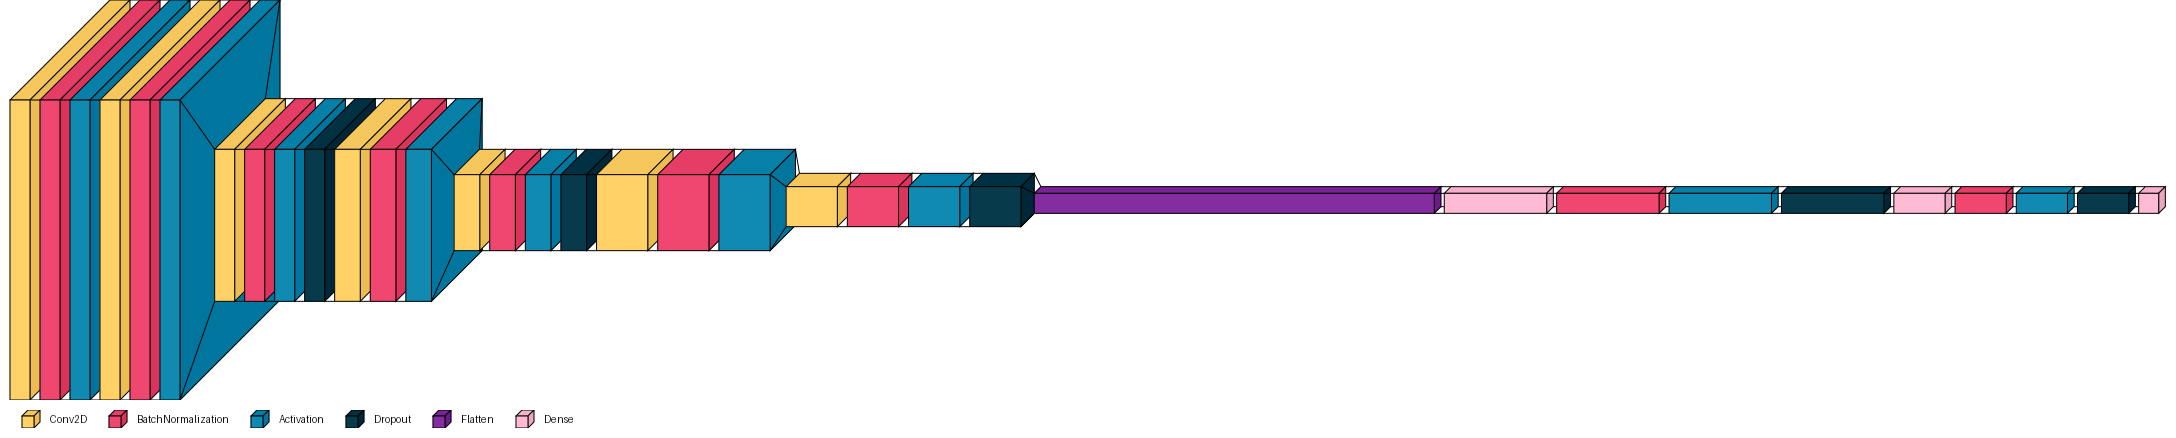

In [29]:
# Se visualiza la red de fomra grafica
visualkeras.layered_view(model,legend=True)

In [ ]:
# =============================================
# 4.4 Entrenamiento
# =============================================
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 600s 1s/step - accuracy: 0.0755 - loss: 5.0969 - val_accuracy: 0.1228 - val_loss: 4.6676 - learning_rate: 0.0010
Epoch 2/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 526s 966ms/step - accuracy: 0.3528 - loss: 3.5257 - val_accuracy: 0.3866 - val_loss: 3.4240 - learning_rate: 0.0010
Epoch 3/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 576s 1s/step - accuracy: 0.5515 - loss: 2.8571 - val_accuracy: 0.6170 - val_loss: 2.7409 - learning_rate: 0.0010
Epoch 4/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 529s 972ms/step - accuracy: 0.6678 - loss: 2.6339 - val_accuracy: 0.5389 - val_loss: 3.2542 - learning_rate: 0.0010
Epoch 5/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 540s 993ms/step - accuracy: 0.7293 - loss: 2.5379 - val_accuracy: 0.7755 - val_loss: 2.3348 - learning_rate: 0.0010
Epoch 6/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 524s 963ms/step - accuracy: 0.7691 - loss: 2.3950 - val_accuracy: 0.7821 - val_loss: 2.4026 - learning_rate: 0.0010
Epoch 7/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 531s 976ms/step - accuracy: 0.

In [ ]:
# =============================================
# 4.5 Guardar Modelo
# =============================================

from google.colab import drive
drive.mount('/content/drive')

# Guarda el modelo en Drive
model.save('/content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA/asl_model_final_F1.h5')

# Verificar que el archivo existe
import os
if os.path.exists('/content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA/asl_model_final_F1.h5'):
    print("✅ Modelo guardado correctamente en Drive!")
else:
    print("❌ Error: Revisa la ruta.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Modelo guardado correctamente en Drive!


5. PRESENTACION DE LOS RESULTADOS DE LA EVALUACION

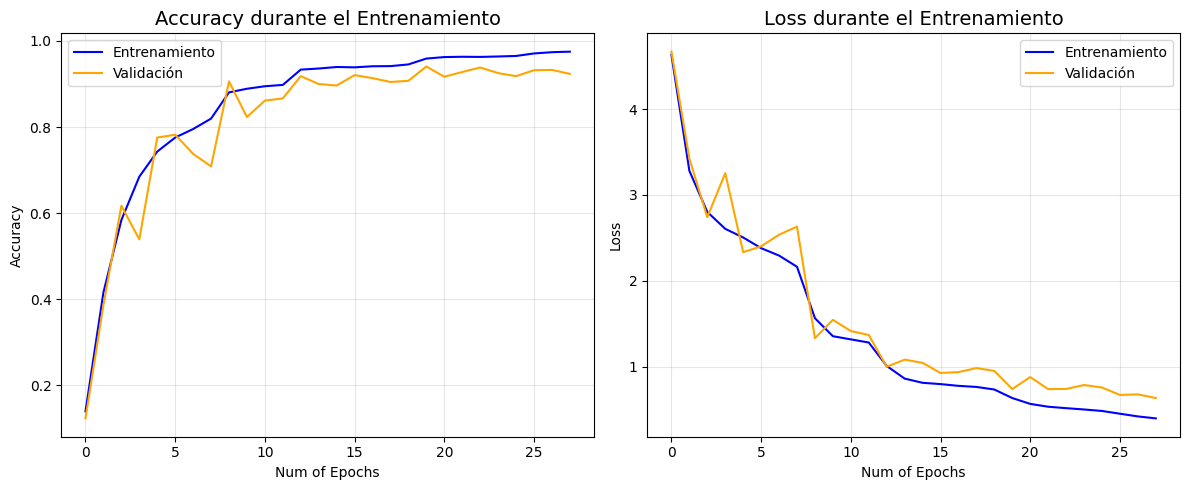

In [ ]:
# =============================================
# Visualizar Curvas de Aprendizaje
# =============================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='blue')
plt.plot(history.history['val_accuracy'], label='Validación', color='orange')
plt.title('Accuracy durante el Entrenamiento', fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('Num of Epochs')
plt.legend()
plt.grid(alpha=0.3)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='blue')
plt.plot(history.history['val_loss'], label='Validación', color='orange')
plt.title('Loss durante el Entrenamiento', fontsize=14)
plt.ylabel('Loss')
plt.xlabel('Num of Epochs')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

6. VALIDACION Y OBTENCION DE LAS PREDICCIONES DEL MODELO

In [30]:
# Check if the file exists
if os.path.exists('/content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA/asl_model_final_F1.h5'):
    print("✅ The model file exists!")
else:
    print("❌ The model file does not exist. Check the file path or make sure the model was saved correctly.")


✅ The model file exists!


In [31]:
# =============================================
# 6.1 Cargar el modelo
# =============================================
model_path = '/content/drive/My Drive/Colab Notebooks/PROYECTO FINAL IA/asl_model_final_F1.h5'
model = load_model(model_path)

# =============================================
# 2. Configurar Generador de Test (CORREGIDO)
# =============================================
target_size = (150, 150)  # Aumentar resolución para mejor precisión (si hardware lo permite)
batch_size = 128           # Ajustar según tu RAM/GPU


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Verificación crítica
print("Clases detectadas:", test_generator.class_indices)  # Debe mostrar 'A', 'B', etc.
print("Número de clases:", test_generator.num_classes)    # Debe ser 29

# Verificación crítica
print(f"Clases detectadas: {test_generator.num_classes}")  # Debe mostrar 29
print(f"Total de imágenes: {test_generator.samples}")  # Verifica el número de imágen

Found 29 images belonging to 29 classes.
Clases detectadas: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
Número de clases: 29
Clases detectadas: 29
Total de imágenes: 29


In [32]:
# =============================================
# 6.2 Evaluar el Modelo
# =============================================
loss, accuracy = model.evaluate(test_generator)
print(f'\n✅ Accuracy en test: {accuracy * 100:.2f}%')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.4839

✅ Accuracy en test: 100.00%


7. PRESENTACION DE LOS RESULTADOS DE LA EVALUACION

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


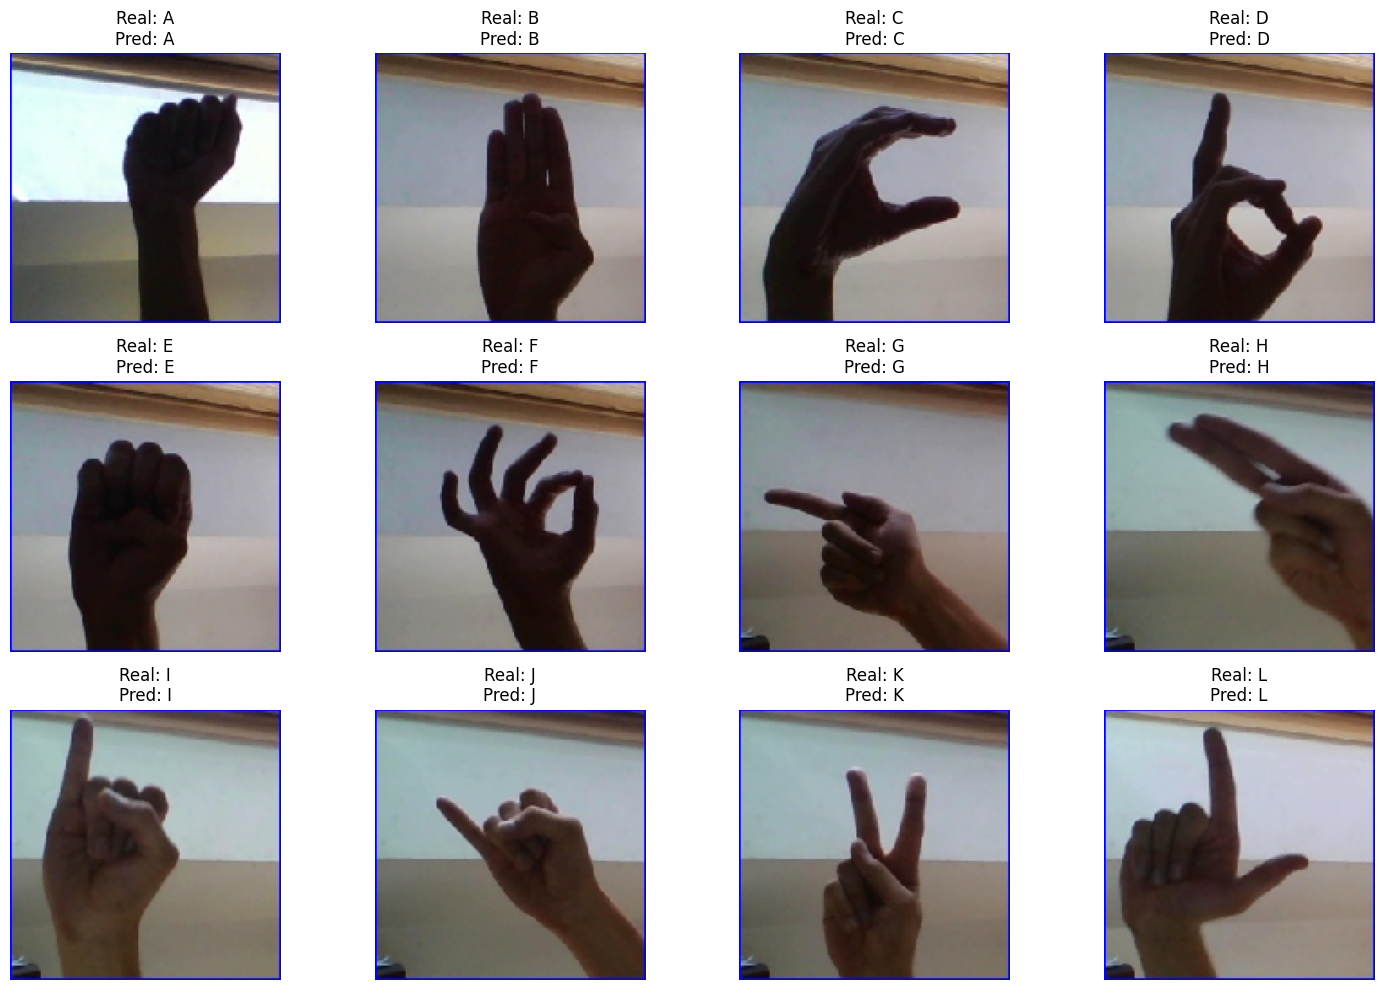

In [33]:
# =============================================
# 7.1 Ver Predicciones en Imágenes de Test
# =============================================

# Obtener un batch de imágenes y etiquetas
test_images, test_labels = next(test_generator)

# Predecir
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Obtener nombres de las clases
class_names = list(test_generator.class_indices.keys())

# Mostrar resultados
plt.figure(figsize=(15, 10))
for i in range(12):  # Muestra 12 imágenes
    plt.subplot(3, 4, i+1)
    plt.imshow(test_images[i])
    plt.title(f'Real: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


<Axes: >

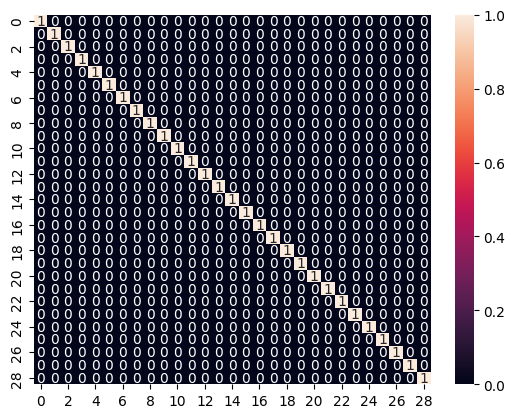

In [34]:
# 7.2 Matriz de confusion
y_true = test_generator.classes
y_pred = model.predict(test_generator).argmax(axis=1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True)

In [35]:
# 7.3 Mtericas de evaluacion en clasificacion
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score, classification_report
loss, accuracy = model.evaluate(test_generator)
print(f'\n✅ Accuracy en test: {accuracy * 100:.2f}%')

#print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='')

report = classification_report(y_true, y_pred, target_names=clases)
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.4839

✅ Accuracy en test: 100.00%
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00         1
           N       1.00      1.00      1.00         1
           O       1.00      1.00      1.00         1
           P       1.00      1.00